# Neural style transfer

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import models, transforms
from PIL import Image

## import stuff

### Load VGG19 pre-trained model

In [ ]:
vgg = models.vgg19(pretrained=True).features
vgg = vgg.to('cuda' if torch.cuda.is_available() else 'cpu')

for param in vgg.parameters():
    param.requires_grad_(False)

### Transform image and get features

In [ ]:
def image_transform(image_name, max_size=512, shape=None):
    image = Image.open(image_name).convert('RGB')
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),
                                             (0.229, 0.224, 0.225))])

    image = in_transform(image)[:3,:,:].unsqueeze(0)
    return image

def get_features(image, model, layers): # get features from layers
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[name] = x
    return features


def gram_matrix(tensor): # calculate gram matrix (for style)
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

### Load style and weights

In [ ]:
style = image_transform("lisafacebig.png").to('cuda' if torch.cuda.is_available() else 'cpu') #  mona lisa

# layers for style and content
style_layers = ['0', '5', '10', '19', '28']

# loss weights
style_weights = {'0': 1., '5': 0.8, '10': 0.5, '19': 0.3, '28': 0.1}
style_grams = {layer: gram_matrix(get_features(style, vgg, style_layers)[layer]) for layer in style_layers}


### Train on mona lisa style

In [ ]:
target = torch.randn_like(style).requires_grad_(True).to('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam([target], lr=0.003)
steps = 3000

In [ ]:
for i in range(1, steps+1):
    target_features = get_features(target, vgg, style_layers)
    style_loss = 0

    for layer in style_layers:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * F.mse_loss(target_gram, style_gram)
        style_loss += layer_style_loss / (target_feature.shape[1] * target_feature.shape[2])

    optimizer.zero_grad()
    style_loss.backward()
    optimizer.step()

    if i % 500 == 0:
        print('Step:', i, 'Style Loss:', style_loss.item())


Step: 500 Style Loss: 31075.330078125
Step: 1000 Style Loss: 11358.462890625
Step: 1500 Style Loss: 7244.490234375
Step: 2000 Style Loss: 5497.27392578125
Step: 2500 Style Loss: 4316.943359375
Step: 3000 Style Loss: 3326.41455078125


### Iteratively apply style to image

In [ ]:
new_content_image_path = "random_face.png"
new_content = image_transform(new_content_image_path).to('cuda' if torch.cuda.is_available() else 'cpu')

new_target = new_content.clone().requires_grad_(True)

optimizer = optim.Adam([new_target], lr=0.003)
steps = 1500

In [ ]:

for i in range(1, steps + 1):
    optimizer.zero_grad()
    new_target_features = get_features(new_target, vgg, style_layers)
    style_loss = 0

    for layer in style_layers:
        target_feature = new_target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * F.mse_loss(target_gram, style_gram)
        style_loss += layer_style_loss / (target_feature.shape[1] * target_feature.shape[2])

    style_loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print('Step:', i, 'Style Loss:', style_loss.item())

Step: 100 Style Loss: 6292.38330078125
Step: 200 Style Loss: 4525.6201171875
Step: 300 Style Loss: 3319.11328125
Step: 400 Style Loss: 2447.756591796875
Step: 500 Style Loss: 1832.6470947265625
Step: 600 Style Loss: 1408.99658203125
Step: 700 Style Loss: 1118.5775146484375
Step: 800 Style Loss: 916.9810791015625
Step: 900 Style Loss: 773.9344482421875
Step: 1000 Style Loss: 669.7864990234375
Step: 1100 Style Loss: 591.2183837890625
Step: 1200 Style Loss: 529.9733276367188
Step: 1300 Style Loss: 480.54132080078125
Step: 1400 Style Loss: 439.54119873046875
Step: 1500 Style Loss: 404.8874816894531


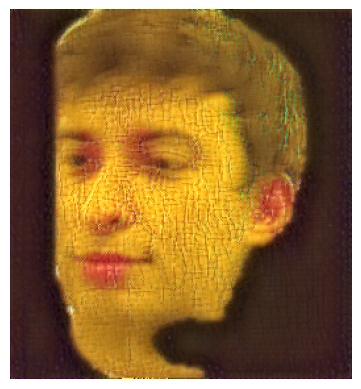

In [ ]:
final_image = new_target.clone().squeeze().detach()
final_image = final_image.cpu().numpy().transpose(1, 2, 0)
final_image = final_image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
final_image = np.clip(final_image, 0, 1)

plt.imshow(final_image)
plt.axis('off')
plt.show()